메모리 네트워크를 사용해 에피소드 데이터에 대한 질의 응답

In [1]:
!pip install tensorflow==2.0.0

In [2]:
!pip install keras==2.3.1

In [3]:
from __future__ import division, print_function


import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [4]:
# 데이터 불러오기
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(Train_File, "rb") 
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers

In [5]:

file_location = "/content/drive/MyDrive/Colab Notebooks/13주차_과제_김정웅(20175308)"

Train_File = os.path.join(file_location, "qa1_single-supporting-fact_train.txt")
Test_File = os.path.join(file_location, "qa1_single-supporting-fact_test.txt")

data_train = get_data(Train_File)
data_test = get_data(Test_File)


print("\n\nTrain observations:",len(data_train[0]),"Test observations:", len(data_test[0]),"\n\n")



Train observations: 10000 Test observations: 10000 




In [6]:
nltk.download('punkt')
# 학습 및 테스트 데이터에서 Vocab 딕셔너리 구축
dictnry = collections.Counter()
for stories,questions,answers in [data_train,data_test]:
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictnry[word.lower()] +=1
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictnry[word.lower()]+=1
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictnry[word.lower()]+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
word2indx = {w:(i+1) for i,(w,_) in enumerate(dictnry.most_common())}

word2indx["PAD"] = 0 # 공백 정의
indx2word = {v:k for k,v in word2indx.items()}

vocab_size = len(word2indx)
print("vocabulary size:",len(word2indx))

vocabulary size: 22


In [8]:
# 각 엔티티의 최대 시퀀스 길이 계산
story_maxlen = 0
question_maxlen = 0

for stories, questions, answers in [data_train,data_test]:
    for story in stories:
        story_len = 0
        for sent in story:
            swords = nltk.word_tokenize(sent)
            story_len += len(swords)
        if story_len > story_maxlen:
            story_maxlen = story_len
            
    for question in questions:
        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len
            
print ("Story maximum length:",story_maxlen,"Question maximum length:",question_maxlen)



Story maximum length: 14 Question maximum length: 4


In [9]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

Using TensorFlow backend.


In [10]:
def data_vectorization(data, word2indx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data

    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] 
                                   for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2indx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2indx[answer.lower()])
        
    return pad_sequences(Xs, maxlen=story_maxlen), pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2indx))


In [11]:
Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2indx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2indx, story_maxlen, question_maxlen)

print("Train story",Xstrain.shape,"Train question", Xqtrain.shape,"Train answer", Ytrain.shape)
print( "Test story",Xstest.shape, "Test question",Xqtest.shape, "Test answer",Ytest.shape)


Train story (10000, 14) Train question (10000, 4) Train answer (10000, 22)
Test story (10000, 14) Test question (10000, 4) Test answer (10000, 22)


In [12]:

EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40


# 입력
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# 스토리 인코더 임베딩
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.2)(story_encoder)

# 질문 인코더 임베딩
question_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

# 스토리와 질문의 일치
match = dot([story_encoder, question_encoder], axes=[2, 2])

# 이야기를 질문의 벡터 공간으로 인코딩
story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)


# 일치한 내용과 스토리 벡터 결합
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# 응답과 질문 벡터를 답변 공간에 결합
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.2)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [13]:
print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 128)      2816        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4, 128)       2816        input_2[0][0]                    
____________________________________________________________________________________________

In [14]:
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=([Xstest, Xqtest], [Ytest]))
                

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 4s 399us/step - loss: 1.9878 - accuracy: 0.2168 - val_loss: 1.6438 - val_accuracy: 0.3193
Epoch 2/40
10000/10000 [==============================] - 3s 318us/step - loss: 1.6509 - accuracy: 0.3107 - val_loss: 1.5832 - val_accuracy: 0.3873
Epoch 3/40
10000/10000 [==============================] - 3s 313us/step - loss: 1.5503 - accuracy: 0.4054 - val_loss: 1.4518 - val_accuracy: 0.4595
Epoch 4/40
10000/10000 [==============================] - 3s 312us/step - loss: 1.4571 - accuracy: 0.4676 - val_loss: 1.3846 - val_accuracy: 0.5015
Epoch 5/40
10000/10000 [==============================] - 3s 319us/step - loss: 1.3888 - accuracy: 0.4934 - val_loss: 1.3221 - val_accuracy: 0.5173
Epoch 6/40
10000/10000 [==============================] - 3s 315us/step - loss: 1.3345 - accuracy: 0.5132 - val_loss: 1.2690 - val_accuracy: 0.5470
Epoch 7/40
10000/10000 [==============================] - 3s 3

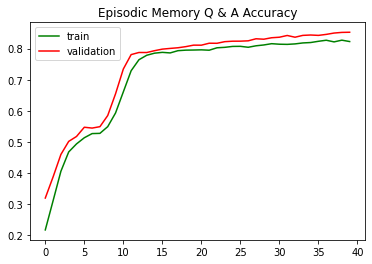

In [18]:
# 정확도와 손실도 플롯
plt.title("Episodic Memory Q & A Accuracy")
plt.plot(history.history["accuracy"], color="g", label="train")
plt.plot(history.history["val_accuracy"], color="r", label="validation")
plt.legend(loc="best")

plt.show()

In [19]:
# Test 데이터 predict(예측)
ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [20]:
# 무작위로 질문을 선택하고 답변을 예측
NUM_DISPLAY = 10
for i in random.sample(range(Xstest.shape[0]),NUM_DISPLAY):
    story = " ".join([indx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([indx2word[x] for x in Xqtest[i].tolist()])
    label = indx2word[ytest[i]]
    prediction = indx2word[ytest_[i]]
    print(story, question, label, prediction)

mary journeyed to the kitchen . daniel journeyed to the bedroom . where is john ? bathroom kitchen
john moved to the office . mary went to the bathroom . where is john ? office office
mary journeyed to the hallway . john went to the hallway . where is mary ? hallway hallway
sandra moved to the garden . sandra journeyed to the hallway . where is sandra ? hallway hallway
sandra journeyed to the office . john went to the garden . where is sandra ? office office
daniel moved to the office . daniel went to the hallway . where is daniel ? hallway hallway
sandra journeyed to the bedroom . mary went to the kitchen . where is sandra ? bedroom bedroom
john went back to the bathroom . john travelled to the kitchen . where is john ? kitchen kitchen
mary journeyed to the kitchen . john moved to the bedroom . where is sandra ? bathroom garden
daniel travelled to the garden . sandra went to the office . where is daniel ? garden garden
